In [197]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import math
import seaborn as sns  # for nicer graphics
from planet import planet

In [20]:
# Load voxel and ground truth t2 data
voxel_train = np.load('voxel_train.npy')
gt_train = np.load('gt_train.npy')

# Split training and test set, 1%
test_size = 100
voxel_test = voxel_train[-test_size:, :]
gt_test = gt_train[-test_size:,:]
voxel_train = voxel_train[:-test_size,:]
gt_train = gt_train[:-test_size,:]

print('Training data:', voxel_train[0,:])
print('Ground Truth T2:', gt_train[0,:])

Training data: [ 0.06421593+0.00327071j  0.11623111+0.06185092j  0.07089394+0.11925318j
 -0.00245724+0.13829132j -0.05461785+0.10650547j -0.05002071+0.03513936j]
Ground Truth T2: [0.1]


In [21]:
# Split testing data according the type of tissue
csf_test = [] # T2 = 1.99
gm_test = []  # T2 = 0.1
wm_test  = [] # T2 = 0.08

for i in range(len(voxel_test)):
    if gt_test[i] == 1.99:
        csf_test.append(voxel_test[i,:])

    if gt_test[i] == 0.1:
        gm_test.append(voxel_test[i,:])
    
    if gt_test[i] == 0.08:
        wm_test.append(voxel_test[i,:])

csf_test = np.asarray(csf_test)
gm_test  = np.asarray(gm_test)
wm_test  = np.asarray(wm_test)
print('CSF:', csf_test[0])
print('GM :', gm_test[0])
print('WM :', wm_test[0])

CSF: [-0.26561016+0.00500844j -0.2902389 -0.16913969j  0.01037011+0.01454221j
  0.00094244+0.33064529j -0.13519567+0.22601325j -0.21343836+0.11832236j]
GM : [0.12992528+0.0008233j  0.11526716+0.06670989j 0.08029675+0.1139364j
 0.00841968+0.06994378j 0.04803873-0.0869916j  0.12554065-0.06770424j]
WM : [ 0.10702994+0.00701721j  0.12521267+0.08156753j  0.07677861+0.12055612j
  0.00525963+0.14973999j -0.06857487+0.13035633j -0.05229969+0.04231305j]


In [39]:
B0 = 3 # main magnetic field
npcs = 6 # number of phase-cycle
alpha = np.deg2rad(30) # alpha = flip angle
TR = 3e-3
pcs = np.linspace(0, 2*np.pi, npcs, endpoint=False)
t1_csf = 4.2
t1_gm  = 0.857 * (B0 ** 0.376)
t1_wm  = 0.583 * (B0 ** 0.382)

_ , _, t2_csf_planet = planet(csf_test[2], alpha, TR, t1_csf, pcs=pcs, compute_df=False)
print('PLANET T2 (CSF):', t2_csf_planet)

_ , _, t2_gm_planet = planet(gm_test[0], alpha, TR, t1_gm, pcs=pcs, compute_df=False)
print('PLANET T2 (GM):', t2_gm_planet)

_ , _, t2_wm_planet = planet(wm_test[0], alpha, TR, t1_wm, pcs=pcs, compute_df=False)
print('PLANET T2 (WM):',t2_wm_planet)

PLANET T2 (CSF): 1.2428820595100185
PLANET T2 (GM): 0.0731725500739854
PLANET T2 (WM): 0.05667432392784511


In [41]:
def split_complex_data(data):
    n = np.zeros([data.shape[0],2*data.shape[1]])
    for i in range(data.shape[1]):
        n[:,2*i] = data[:,i].real
        n[:,2*i+1] = data[:,i].imag
    return n

In [44]:
new_voxel_train = split_complex_data(voxel_train)
print('Complex voxel data split into real and imaginary parts:', new_voxel_train[0,:])
new_voxel_test = split_complex_data(voxel_test)

Complex voxel data split into real and imaginary parts: [ 0.06421593  0.00327071  0.11623111  0.06185092  0.07089394  0.11925318
 -0.00245724  0.13829132 -0.05461785  0.10650547 -0.05002071  0.03513936]


In [46]:
# Define the network structure
inputs = tf.keras.Input(shape=(12,)) #number of inputs
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(inputs)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x) # no. of outputs
#outputs=tf.keras.layers.Dense(1, activation=tf.keras.activations.relu, kernel_initializer='normal',bias_initializer=tf.keras.initializers.Constant(0.1))(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [47]:
# Define optimizer and train the network

# To save the model for each epoch, uncomment the checkpoint_callback below
# checkpoint_callback=tf.keras.callbacks.ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True mode='auto', save_freq='epoch')

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='mse', metrics='mse')

start=time.time()

history = model.fit(new_voxel_train, gt_train,epochs=10, batch_size=10, validation_split=0.1)  # starts training

# 2nd set of parameters
# model.fit(voxel_train, gt_train,epochs=100, batch_size=100, validation_data=(voxel_valid,gt_valid),callbacks=[checkpoint_callback])  # starts training

end=time.time()
print('Time Elapsed:%i seconds'%(end-start))

Epoch 1/10
891/891 [==============================] - 1s 1ms/step - loss: 0.0993 - mse: 0.0993 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 2/10
891/891 [==============================] - 1s 1ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 3/10
891/891 [==============================] - 1s 1ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 4/10
891/891 [==============================] - 1s 1ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 5/10
891/891 [==============================] - 1s 978us/step - loss: 0.0014 - mse: 0.0014 - val_loss: 8.1538e-04 - val_mse: 8.1538e-04
Epoch 6/10
891/891 [==============================] - 1s 977us/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 7/10
891/891 [==============================] - 1s 970us/step - loss: 8.2784e-04 - mse: 8.2784e-04 - val_loss: 1.9235e-04 - val_mse: 1.9235e-04
Epoch 8/10
891/891 [==========================

In [7]:
model = tf.keras.models.load_model('voxel_regression')

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


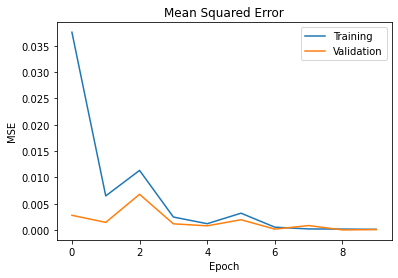

In [48]:
#print(model.summary())
print(history.history.keys())

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [49]:
results = model.evaluate(new_voxel_test, gt_test, batch_size=10)
print("test loss, test mse:", results)

10/10 [==============================] - 0s 554us/step - loss: 1.2036e-04 - mse: 1.2036e-04
test loss, test mse: [0.00012036004773108289, 0.00012036004773108289]


In [50]:
gt_predict = model.predict(new_voxel_test[0:10,:])
# show the ground truth and predicted outputs
for i in range(len(voxel_test[0:10,:])):
	print("Actual T2=%s, Predicted=%s" % (gt_test[i], gt_predict[i]))

Actual T2=[0.08], Predicted=[0.07507858]
Actual T2=[0.1], Predicted=[0.09720512]
Actual T2=[0.1], Predicted=[0.08886024]
Actual T2=[0.1], Predicted=[0.08839215]
Actual T2=[0.1], Predicted=[0.08984914]
Actual T2=[0.1], Predicted=[0.09300992]
Actual T2=[0.08], Predicted=[0.07464772]
Actual T2=[0.1], Predicted=[0.09437842]
Actual T2=[0.1], Predicted=[0.09806706]
Actual T2=[0.1], Predicted=[0.09621514]


In [27]:
#model.save('voxel_regression')

INFO:tensorflow:Assets written to: voxel_regression\assets


In [124]:
# Monte Carlo Simulation
def monte_carlo(n):
    pdf = [] #empty list to store probability value
    result = 0
    predicted_t2 = model.predict(n)
    
    for i in range(len(predicted_t2)):
        result = result + predicted_t2[i]
        pdf.append(result/(i+1)) #append result of each iteration to the empty list

    pdf  = np.asarray(pdf)
    return result/len(n), pdf

In [125]:
# Split testing data according the type of tissue
new_csf_test = [] # T2 = 1.99
new_gm_test = []  # T2 = 0.1
new_wm_test  = [] # T2 = 0.08

for i in range(len(new_voxel_test)):
    if gt_test[i] == 1.99:
        new_csf_test.append(new_voxel_test[i,:])

    if gt_test[i] == 0.1:
        new_gm_test.append(new_voxel_test[i,:])
    
    if gt_test[i] == 0.08:
        new_wm_test.append(new_voxel_test[i,:])

new_csf_test = np.asarray(new_csf_test)
new_gm_test  = np.asarray(new_gm_test)
new_wm_test  = np.asarray(new_wm_test)
print('CSF:', new_csf_test[0])

CSF: [-0.26561016  0.00500844 -0.2902389  -0.16913969  0.01037011  0.01454221
  0.00094244  0.33064529 -0.13519567  0.22601325 -0.21343836  0.11832236]


Text(0, 0.5, 'Probability')

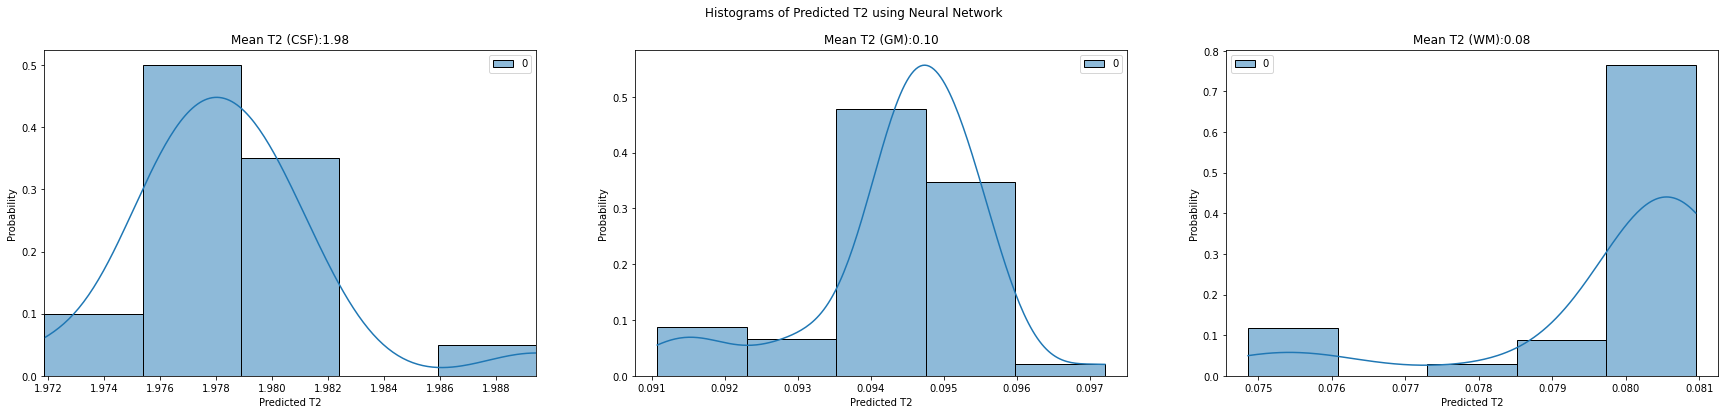

In [205]:
mean_csf_t2, csf_pdf = monte_carlo(new_csf_test) 
mean_gm_t2, gm_pdf = monte_carlo(new_gm_test)
mean_wm_t2, wm_pdf = monte_carlo(new_wm_test)

bins = 5
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))
fig.suptitle('Histograms of Predicted T2 using Neural Network')
sns.histplot(data=csf_pdf, bins=bins, stat='probability', kde=True, ax=ax1)
ax1.set_xlim((df["value"].min(), df["value"].max()))
ax1.set_title('Mean T2 (CSF):%.2f' %mean_csf_t2)
ax1.set_xlabel('Predicted T2')
ax1.set_ylabel('Probability')

sns.histplot(data=gm_pdf, bins=bins, stat='probability', kde=True, ax=ax2)
ax2.set_title('Mean T2 (GM):%.2f' %mean_gm_t2)
ax2.set_xlabel('Predicted T2')
ax2.set_ylabel('Probability')

sns.histplot(data=wm_pdf, bins=bins, stat='probability', kde=True, ax=ax3)
ax3.set_title('Mean T2 (WM):%.2f' %mean_wm_t2)
ax3.set_xlabel('Predicted T2')
ax3.set_ylabel('Probability')